# Notebook 06: Combined Defense Strategies & System Validation

This final notebook stress-tests the Federated Learning-based Intrusion Detection System (FL-IDS) under realistic and adversarial IIoT conditions.

We evaluate the system’s robustness by combining concept drift and model poisoning attacks simultaneously and pushing the system toward its breaking points.

## Objectives

- Simulate combined adversarial conditions:
  - Drifted clients (via statistical drift injection)
  - Byzantine attackers (e.g., scaling, Sybil)
- Evaluate defense mechanisms:
  - Median Aggregation
  - Krum Aggregation
  - Drift-Aware Adaptive Weighting
- Push scaling attacks beyond prior experiments for boundary testing
- Document when and how the system fails or holds (F1, FP/FN rates)
- Validate the practical resilience of FL-IDS for edge deployments

This notebook completes the validation pipeline by integrating all developed defense strategies under challenging conditions.


In [2]:
# === Combined Defense Evaluation ===
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import joblib
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.models import load_model, clone_model
from tensorflow.keras.losses import MeanSquaredError

# === Reproducibility ===
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# === Paths ===
base_path = "D:/August-Thesis/FL-IDS-Surveillance"
results_path = os.path.join(base_path, "notebooks/results")
model_path = os.path.join(results_path, "models/unsupervised/federated/final_federated_autoencoder_20rounds.h5")
scaler_path = os.path.join(results_path, "scalers/minmax_scaler_client_3.pkl")
standard_scaler_path = os.path.join(results_path, "scalers/standard_scaler_client_3.pkl")
test_path = os.path.join(base_path, "data/processed/surv_unsupervised/test_mixed.csv")
data_path = os.path.join(base_path, "data/processed/federated/unsupervised")
client_ids = [f"client_{i}" for i in range(1, 6)]

# === Load Global Model & Scaler ===
global_model = load_model(model_path, compile=False)
global_model.compile(optimizer="adam", loss=MeanSquaredError())
minmax_scaler = joblib.load(scaler_path)

# === Load Client Data ===
client_dfs = {
    cid: pd.read_csv(os.path.join(data_path, cid, "train.csv"))
    for cid in client_ids
}

# load the test data
test_df = pd.read_csv(test_path)
feature_cols = list(minmax_scaler.feature_names_in_)
X_test_scaled = minmax_scaler.transform(test_df[feature_cols])
y_true = test_df["Attack_label"].values

# Print he details of the loaded
print("Setup complete.")
print(f"Loaded model: {os.path.basename(model_path)}")
print(f"Clients: {client_ids}")
print(f"Test samples: {X_test_scaled.shape[0]}")


C:\Users\ASSEM\AppData\Local\Temp\ipykernel_25492\274987875.py:40: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(test_path)


Setup complete.
Loaded model: final_federated_autoencoder_20rounds.h5
Clients: ['client_1', 'client_2', 'client_3', 'client_4', 'client_5']
Test samples: 2218834


In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score

threshold = 0.000639

# Predict with global model on test set
reconstructed = global_model.predict(X_test_scaled, verbose=0)
reconstruction_errors = np.mean(np.square(X_test_scaled - reconstructed), axis=1)

# === Binary classification based on threshold ===
y_pred = (reconstruction_errors > threshold).astype(int)

# Evaluation Metrics
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("=== Baseline Performance ===")
print(f"F1 Score:     {f1:.4f}")
print(f"Precision:    {precision:.4f}")
print(f"Recall:       {recall:.4f}")


=== Baseline Performance ===
F1 Score:     0.8373
Precision:    0.9877
Recall:       0.7266


In [4]:
# === Attack Injection Utilities ===

def sign_flipping_attack(global_weights, local_weights, scale_factor=1.0):
    """Inverts and scales the difference between local and global weights."""
    return [gw - scale_factor * (lw - gw) for gw, lw in zip(global_weights, local_weights)]

def scaling_attack(global_weights, local_weights, scale_factor=10.0):
    """Amplifies the update from the attacker before submission."""
    return [gw + scale_factor * (lw - gw) for gw, lw in zip(global_weights, local_weights)]

def adaptive_gradient_attack(global_weights, local_weights, learning_rate=1.0, noise_std=0.0):
    """Crafted gradient-based attack with optional noise."""
    poisoned_weights = []
    for gw, lw in zip(global_weights, local_weights):
        gradient = lw - gw
        if noise_std > 0:
            noise = np.random.normal(loc=0.0, scale=noise_std, size=gradient.shape)
            gradient += noise
        poisoned_weights.append(gw + learning_rate * gradient)
    return poisoned_weights

def generate_sybil_updates(poisoned_weights, num_sybil_nodes):
    """Copies the same malicious update for multiple fake clients (Sybil attack)."""
    return [poisoned_weights for _ in range(num_sybil_nodes)]


# === Drift Injection Utility ===

def inject_drift(client_df, features_to_drift, scale_factors):
    """Applies multiplicative drift to selected features."""
    drifted_df = client_df.copy()
    for feature, factor in zip(features_to_drift, scale_factors):
        if feature in drifted_df.columns:
            drifted_df[feature] *= factor
    return drifted_df


In [5]:
def run_combined_simulation(
    global_model,
    client_dfs,
    scaler,
    feature_names,
    X_test_scaled,
    y_true,
    poisoned_clients=["client_3"],
    drifted_clients=["client_4"],
    attack_type="scaling",  # Options: "scaling", "sign", "adaptive"
    scale_factor=50,
    drift_features=None,
    drift_factors=None,
    aggregation="fedavg",  # Options: "fedavg", "median"
    threshold=0.000639,
    num_rounds=20,
    attack_start=6,
    verbose=True
):
    model = clone_model(global_model)
    model.set_weights(global_model.get_weights())
    model.compile(optimizer="adam", loss=MeanSquaredError())

    metrics_log = []

    for round_num in range(1, num_rounds + 1):
        collected_weights = []

        for cid in client_ids:
            df = client_dfs[cid]

            # Inject drift if client is in drift list
            if cid in drifted_clients and drift_features and drift_factors:
                df = inject_drift(df, drift_features, drift_factors)

            X_local = df[feature_names].astype(float)
            X_scaled = scaler.transform(X_local)

            local_model = clone_model(model)
            local_model.set_weights(model.get_weights())
            local_model.compile(optimizer="adam", loss=MeanSquaredError())
            local_model.fit(X_scaled, X_scaled, epochs=1, batch_size=256, verbose=0)

            weights = local_model.get_weights()

            # Inject attack if client is in attack list and attack round has started
            if cid in poisoned_clients and round_num >= attack_start:
                if attack_type == "scaling":
                    weights = scaling_attack(model.get_weights(), weights, scale_factor=scale_factor)
                elif attack_type == "sign":
                    weights = sign_flipping_attack(model.get_weights(), weights, scale_factor=scale_factor)
                elif attack_type == "adaptive":
                    weights = adaptive_gradient_attack(model.get_weights(), weights, learning_rate=scale_factor)

            collected_weights.append(weights)

        # The aggregation part
        if aggregation == "fedavg":
            aggregated_weights = [
                np.mean([w[i] for w in collected_weights], axis=0)
                for i in range(len(collected_weights[0]))
            ]
        elif aggregation == "median":
            aggregated_weights = [
                np.median(np.stack([w[i] for w in collected_weights]), axis=0)
                for i in range(len(collected_weights[0]))
            ]
        else:
            raise ValueError("Unsupported aggregation method")

        model.set_weights(aggregated_weights)

        # Evaluation of the global model
        preds = model.predict(X_test_scaled, verbose=0)
        errors = np.mean(np.square(X_test_scaled - preds), axis=1)
        y_pred = (errors > threshold).astype(int)

        f1 = f1_score(y_true, y_pred)
        p = precision_score(y_true, y_pred)
        r = recall_score(y_true, y_pred)
        fp_rate = np.mean((y_pred == 1) & (y_true == 0))
        fn_rate = np.mean((y_pred == 0) & (y_true == 1))

        if verbose:
            print(f"{aggregation.upper()} | Round {round_num:02d} | F1: {f1:.4f} | P: {p:.4f} | R: {r:.4f} | FP Rate: {fp_rate:.4f} | FN Rate: {fn_rate:.4f}")

        metrics_log.append({
            "Round": round_num,
            "F1": f1,
            "Precision": p,
            "Recall": r,
            "FP Rate": fp_rate,
            "FN Rate": fn_rate
        })

    return pd.DataFrame(metrics_log)


In [6]:
# === Calculate variance per feature across all clients ===
combined_df = pd.concat([df[feature_cols] for df in client_dfs.values()], axis=0)
feature_variances = combined_df.var().sort_values(ascending=False)

# === Select top 3 most variable features ===
drift_features = feature_variances.head(3).index.tolist()
drift_factors = [1.5, 0.7, 2.0]  # the distortion factors (for consistency)

print("Top 3 high-variance features selected for drift injection:")
for feat in drift_features:
    print(f"- {feat}")


Top 3 high-variance features selected for drift injection:
- tcp.ack_raw
- tcp.seq
- tcp.ack


In [7]:
# === Define features to drift and drift factors ===
drift_features = ["tcp.ack_raw", "tcp.seq", "tcp.ack"]
drift_factors = [1.5, 0.7, 2.0]    # Arbitrary distortion

# === Run simulation ===
combined_results_fedavg = run_combined_simulation(
    global_model=global_model,
    client_dfs=client_dfs,
    scaler=minmax_scaler,
    feature_names=feature_cols,
    X_test_scaled=X_test_scaled,
    y_true=y_true,
    poisoned_clients=["client_3"],
    drifted_clients=["client_4"],
    attack_type="scaling",
    scale_factor=50,
    drift_features=drift_features,
    drift_factors=drift_factors,
    aggregation="fedavg",
    threshold=0.000639,
    num_rounds=20,
    attack_start=6,
    verbose=True
)


FEDAVG | Round 01 | F1: 0.8368 | P: 0.9878 | R: 0.7259 | FP Rate: 0.0024 | FN Rate: 0.0745
FEDAVG | Round 02 | F1: 0.8364 | P: 0.9879 | R: 0.7252 | FP Rate: 0.0024 | FN Rate: 0.0747
FEDAVG | Round 03 | F1: 0.8359 | P: 0.9879 | R: 0.7243 | FP Rate: 0.0024 | FN Rate: 0.0749
FEDAVG | Round 04 | F1: 0.8356 | P: 0.9879 | R: 0.7240 | FP Rate: 0.0024 | FN Rate: 0.0750
FEDAVG | Round 05 | F1: 0.8353 | P: 0.9879 | R: 0.7235 | FP Rate: 0.0024 | FN Rate: 0.0752
FEDAVG | Round 06 | F1: 0.5732 | P: 0.4296 | R: 0.8611 | FP Rate: 0.3109 | FN Rate: 0.0378
FEDAVG | Round 07 | F1: 0.4275 | P: 0.2719 | R: 1.0000 | FP Rate: 0.7281 | FN Rate: 0.0000
FEDAVG | Round 08 | F1: 0.4275 | P: 0.2719 | R: 1.0000 | FP Rate: 0.7281 | FN Rate: 0.0000
FEDAVG | Round 09 | F1: 0.4275 | P: 0.2719 | R: 1.0000 | FP Rate: 0.7281 | FN Rate: 0.0000
FEDAVG | Round 10 | F1: 0.4275 | P: 0.2719 | R: 1.0000 | FP Rate: 0.7281 | FN Rate: 0.0000
FEDAVG | Round 11 | F1: 0.4275 | P: 0.2719 | R: 1.0000 | FP Rate: 0.7281 | FN Rate: 0.0000

In [8]:
combined_results_median = run_combined_simulation(
    global_model=global_model,
    client_dfs=client_dfs,
    scaler=minmax_scaler,
    feature_names=feature_cols,
    X_test_scaled=X_test_scaled,
    y_true=y_true,
    poisoned_clients=["client_3"],
    drifted_clients=["client_4"],
    attack_type="scaling",
    scale_factor=50,
    drift_features=drift_features,
    drift_factors=drift_factors,
    aggregation="median",  
    threshold=0.000639,
    num_rounds=20,
    attack_start=6,
    verbose=True
)


MEDIAN | Round 01 | F1: 0.8366 | P: 0.9878 | R: 0.7256 | FP Rate: 0.0024 | FN Rate: 0.0746
MEDIAN | Round 02 | F1: 0.8372 | P: 0.9879 | R: 0.7263 | FP Rate: 0.0024 | FN Rate: 0.0744
MEDIAN | Round 03 | F1: 0.8370 | P: 0.9880 | R: 0.7260 | FP Rate: 0.0024 | FN Rate: 0.0745
MEDIAN | Round 04 | F1: 0.8351 | P: 0.9879 | R: 0.7232 | FP Rate: 0.0024 | FN Rate: 0.0752
MEDIAN | Round 05 | F1: 0.8355 | P: 0.9879 | R: 0.7237 | FP Rate: 0.0024 | FN Rate: 0.0751
MEDIAN | Round 06 | F1: 0.8362 | P: 0.9880 | R: 0.7248 | FP Rate: 0.0024 | FN Rate: 0.0748
MEDIAN | Round 07 | F1: 0.8341 | P: 0.9876 | R: 0.7219 | FP Rate: 0.0025 | FN Rate: 0.0756
MEDIAN | Round 08 | F1: 0.8346 | P: 0.9884 | R: 0.7221 | FP Rate: 0.0023 | FN Rate: 0.0755
MEDIAN | Round 09 | F1: 0.8309 | P: 0.9883 | R: 0.7168 | FP Rate: 0.0023 | FN Rate: 0.0770
MEDIAN | Round 10 | F1: 0.8305 | P: 0.9886 | R: 0.7160 | FP Rate: 0.0022 | FN Rate: 0.0772
MEDIAN | Round 11 | F1: 0.8313 | P: 0.9886 | R: 0.7172 | FP Rate: 0.0022 | FN Rate: 0.0769

In [9]:
def krum_aggregate(client_weights_list, num_adv=1):
    """
    Implements Krum aggregation to defend against Byzantine clients.
    Selects one client update (the most trustworthy one).
    """
    num_clients = len(client_weights_list)
    distances = []

    for i, weights_i in enumerate(client_weights_list):
        dists = []
        for j, weights_j in enumerate(client_weights_list):
            if i != j:
                dist = sum(np.linalg.norm(wi - wj) ** 2 for wi, wj in zip(weights_i, weights_j))
                dists.append(dist)
        dists.sort()
        score = sum(dists[:num_clients - num_adv - 2]) 
        distances.append((i, score))

    selected_idx = sorted(distances, key=lambda x: x[1])[0][0]
    return client_weights_list[selected_idx]


In [10]:
# === Modified version of the simulation with Krum ===
def run_combined_with_krum(
    global_model,
    client_dfs,
    scaler,
    feature_names,
    X_test_scaled,
    y_true,
    poisoned_clients=["client_3"],
    drifted_clients=["client_4"],
    attack_type="scaling",
    scale_factor=50,
    drift_features=None,
    drift_factors=None,
    threshold=0.000639,
    num_rounds=20,
    attack_start=6,
    verbose=True
):
    model = clone_model(global_model)
    model.set_weights(global_model.get_weights())
    model.compile(optimizer="adam", loss=MeanSquaredError())

    metrics_log = []

    for round_num in range(1, num_rounds + 1):
        collected_weights = []

        for cid in client_ids:
            df = client_dfs[cid]

            if cid in drifted_clients and drift_features and drift_factors:
                df = inject_drift(df, drift_features, drift_factors)

            X_local = df[feature_names].astype(float)
            X_scaled = scaler.transform(X_local)

            local_model = clone_model(model)
            local_model.set_weights(model.get_weights())
            local_model.compile(optimizer="adam", loss=MeanSquaredError())
            local_model.fit(X_scaled, X_scaled, epochs=1, batch_size=256, verbose=0)

            weights = local_model.get_weights()

            if cid in poisoned_clients and round_num >= attack_start:
                if attack_type == "scaling":
                    weights = scaling_attack(model.get_weights(), weights, scale_factor=scale_factor)
                elif attack_type == "sign":
                    weights = sign_flipping_attack(model.get_weights(), weights, scale_factor=scale_factor)
                elif attack_type == "adaptive":
                    weights = adaptive_gradient_attack(model.get_weights(), weights, learning_rate=scale_factor)

            collected_weights.append(weights)

        aggregated_weights = krum_aggregate(collected_weights)

        model.set_weights(aggregated_weights)

        preds = model.predict(X_test_scaled, verbose=0)
        errors = np.mean(np.square(X_test_scaled - preds), axis=1)
        y_pred = (errors > threshold).astype(int)

        f1 = f1_score(y_true, y_pred)
        p = precision_score(y_true, y_pred)
        r = recall_score(y_true, y_pred)
        fp_rate = np.mean((y_pred == 1) & (y_true == 0))
        fn_rate = np.mean((y_pred == 0) & (y_true == 1))

        if verbose:
            print(f"KRUM | Round {round_num:02d} | F1: {f1:.4f} | P: {p:.4f} | R: {r:.4f} | FP Rate: {fp_rate:.4f} | FN Rate: {fn_rate:.4f}")

        metrics_log.append({
            "Round": round_num,
            "F1": f1,
            "Precision": p,
            "Recall": r,
            "FP Rate": fp_rate,
            "FN Rate": fn_rate
        })

    return pd.DataFrame(metrics_log)


In [11]:
combined_results_krum = run_combined_with_krum(
    global_model=global_model,
    client_dfs=client_dfs,
    scaler=minmax_scaler,
    feature_names=feature_cols,
    X_test_scaled=X_test_scaled,
    y_true=y_true,
    poisoned_clients=["client_3"],
    drifted_clients=["client_4"],
    attack_type="scaling",
    scale_factor=50,
    drift_features=drift_features,
    drift_factors=drift_factors,
    threshold=0.000639,
    num_rounds=20,
    attack_start=6,
    verbose=True
)


KRUM | Round 01 | F1: 0.8385 | P: 0.9878 | R: 0.7284 | FP Rate: 0.0024 | FN Rate: 0.0738
KRUM | Round 02 | F1: 0.8379 | P: 0.9879 | R: 0.7275 | FP Rate: 0.0024 | FN Rate: 0.0741
KRUM | Round 03 | F1: 0.8383 | P: 0.9880 | R: 0.7280 | FP Rate: 0.0024 | FN Rate: 0.0739
KRUM | Round 04 | F1: 0.8373 | P: 0.9880 | R: 0.7265 | FP Rate: 0.0024 | FN Rate: 0.0743
KRUM | Round 05 | F1: 0.8367 | P: 0.9880 | R: 0.7256 | FP Rate: 0.0024 | FN Rate: 0.0746
KRUM | Round 06 | F1: 0.8342 | P: 0.9879 | R: 0.7219 | FP Rate: 0.0024 | FN Rate: 0.0756
KRUM | Round 07 | F1: 0.8328 | P: 0.9879 | R: 0.7198 | FP Rate: 0.0024 | FN Rate: 0.0762
KRUM | Round 08 | F1: 0.8328 | P: 0.9879 | R: 0.7198 | FP Rate: 0.0024 | FN Rate: 0.0762
KRUM | Round 09 | F1: 0.8311 | P: 0.9878 | R: 0.7173 | FP Rate: 0.0024 | FN Rate: 0.0769
KRUM | Round 10 | F1: 0.8301 | P: 0.9882 | R: 0.7156 | FP Rate: 0.0023 | FN Rate: 0.0773
KRUM | Round 11 | F1: 0.8320 | P: 0.9883 | R: 0.7184 | FP Rate: 0.0023 | FN Rate: 0.0766
KRUM | Round 12 | F1:

## Evaluation of Aggregation Strategies under Combined Drift + Attack

This experiment evaluates the robustness of three FL aggregation strategies — **FedAvg**, **Median**, and **Krum** — under simultaneous concept drift (Client 4) and scaling attack (Client 3). 

### Experimental Setup
- **Poisoned client**: Client 3 (scaling attack with factor = 50)
- **Drifted client**: Client 4 (drift injected on top-3 high-variance features: `tcp.ack_raw`, `tcp.seq`, `tcp.ack`)
- **Defense methods**: FedAvg, Median, Krum
- **Tested for**: 20 rounds (attack starts from Round 6)

### Aggregation Method Comparison

| Aggregator | F1 Score Trend | Precision | Recall | FP Rate (%) | FN Rate (%) | Observed Behavior |
|------------|----------------|-----------|--------|-------------|-------------|--------------------|
| **FedAvg** | 0.83 → **0.42** | ↓ to 0.27 | ↑ to 1.00 | **↑ to 72.8%** | ↓ to 0.0% | Complete collapse — mislabels all data as attack |
| **Median** | 0.83 → 0.82 | Stable at ~0.988 | Slight drop to 0.70 | ~0.22% | ↑ to 8.1% | Robust and stable — slight recall loss |
| **Krum** | 0.84 → 0.83 | Stable at ~0.988 | Slight drop to 0.71 | ~0.22% | ↑ to 7.8% | Equally robust — rejects poisoned update |

### Key Insights

- **FedAvg is vulnerable** to scaling attacks even with a single malicious client.
- **Median and Krum** maintain performance under joint poisoning and drift.
- Slight recall reduction in robust methods is acceptable trade-off for high overall resilience.

These results confirm the importance of using **robust or adaptive aggregators** for real-world federated deployments.


In [12]:
from scipy import stats

def ks_drift_score(reference_data, client_data, feature_names, significance_level=0.05):
    """Count of features that drifted significantly using KS-test."""
    drifted_features = 0
    for feature in feature_names:
        ks_stat, p_value = stats.ks_2samp(reference_data[feature], client_data[feature])
        if p_value < significance_level:
            drifted_features += 1
    return drifted_features

def weighted_fedavg(client_weights_list, drift_scores, epsilon=1e-6):
    """Inverse-score-based weighting: less weight to clients with higher drift."""
    max_score = max(drift_scores) + epsilon
    weights = [(max_score - score) for score in drift_scores]
    weight_sum = sum(weights)
    normalized_weights = [w / weight_sum for w in weights]

    aggregated_weights = []
    for i in range(len(client_weights_list[0])):
        weighted_sum = sum(normalized_weights[j] * client_weights_list[j][i] for j in range(len(client_weights_list)))
        aggregated_weights.append(weighted_sum)

    return aggregated_weights


In [13]:
def run_combined_weighted_fedavg(
    global_model,
    client_dfs,
    scaler,
    feature_names,
    X_test_scaled,
    y_true,
    poisoned_clients=["client_3"],
    drifted_clients=["client_4"],
    reference_client="client_1",
    attack_type="scaling",
    scale_factor=50,
    drift_features=None,
    drift_factors=None,
    threshold=0.000639,
    num_rounds=20,
    attack_start=6,
    verbose=True
):
    model = clone_model(global_model)
    model.set_weights(global_model.get_weights())
    model.compile(optimizer="adam", loss=MeanSquaredError())

    metrics_log = []

    for round_num in range(1, num_rounds + 1):
        collected_weights = []
        drift_scores = []

        for cid in client_ids:
            df = client_dfs[cid]

            if cid in drifted_clients and drift_features and drift_factors:
                df = inject_drift(df, drift_features, drift_factors)

            X_local = df[feature_names].astype(float)
            X_scaled = scaler.transform(X_local)

            local_model = clone_model(model)
            local_model.set_weights(model.get_weights())
            local_model.compile(optimizer="adam", loss=MeanSquaredError())
            local_model.fit(X_scaled, X_scaled, epochs=1, batch_size=256, verbose=0)

            weights = local_model.get_weights()

            if cid in poisoned_clients and round_num >= attack_start:
                if attack_type == "scaling":
                    weights = scaling_attack(model.get_weights(), weights, scale_factor=scale_factor)
                elif attack_type == "sign":
                    weights = sign_flipping_attack(model.get_weights(), weights, scale_factor=scale_factor)
                elif attack_type == "adaptive":
                    weights = adaptive_gradient_attack(model.get_weights(), weights, learning_rate=scale_factor)

            collected_weights.append(weights)

            # === KS Drift Score compared to reference ===
            drift_score = ks_drift_score(client_dfs[reference_client], df, feature_names)
            drift_scores.append(drift_score)

        # Drift-aware weighted aggregation
        aggregated_weights = weighted_fedavg(collected_weights, drift_scores)

        model.set_weights(aggregated_weights)

        preds = model.predict(X_test_scaled, verbose=0)
        errors = np.mean(np.square(X_test_scaled - preds), axis=1)
        y_pred = (errors > threshold).astype(int)

        f1 = f1_score(y_true, y_pred)
        p = precision_score(y_true, y_pred)
        r = recall_score(y_true, y_pred)
        fp_rate = np.mean((y_pred == 1) & (y_true == 0))
        fn_rate = np.mean((y_pred == 0) & (y_true == 1))

        if verbose:
            print(f"DriftAwareFedAvg | Round {round_num:02d} | F1: {f1:.4f} | P: {p:.4f} | R: {r:.4f} | FP Rate: {fp_rate:.4f} | FN Rate: {fn_rate:.4f}")

        metrics_log.append({
            "Round": round_num,
            "F1": f1,
            "Precision": p,
            "Recall": r,
            "FP Rate": fp_rate,
            "FN Rate": fn_rate
        })

    return pd.DataFrame(metrics_log)


In [14]:
combined_results_driftaware = run_combined_weighted_fedavg(
    global_model=global_model,
    client_dfs=client_dfs,
    scaler=minmax_scaler,
    feature_names=feature_cols,
    X_test_scaled=X_test_scaled,
    y_true=y_true,
    poisoned_clients=["client_3"],
    drifted_clients=["client_4"],
    reference_client="client_1",
    attack_type="scaling",
    scale_factor=50,
    drift_features=drift_features,
    drift_factors=drift_factors,
    threshold=0.000639,
    num_rounds=20,
    attack_start=6,
    verbose=True
)


DriftAwareFedAvg | Round 01 | F1: 0.8371 | P: 0.9878 | R: 0.7263 | FP Rate: 0.0024 | FN Rate: 0.0744
DriftAwareFedAvg | Round 02 | F1: 0.8368 | P: 0.9879 | R: 0.7258 | FP Rate: 0.0024 | FN Rate: 0.0745
DriftAwareFedAvg | Round 03 | F1: 0.8362 | P: 0.9879 | R: 0.7249 | FP Rate: 0.0024 | FN Rate: 0.0748
DriftAwareFedAvg | Round 04 | F1: 0.8356 | P: 0.9879 | R: 0.7240 | FP Rate: 0.0024 | FN Rate: 0.0750
DriftAwareFedAvg | Round 05 | F1: 0.8352 | P: 0.9879 | R: 0.7234 | FP Rate: 0.0024 | FN Rate: 0.0752
DriftAwareFedAvg | Round 06 | F1: 0.6352 | P: 0.5551 | R: 0.7423 | FP Rate: 0.1617 | FN Rate: 0.0700
DriftAwareFedAvg | Round 07 | F1: 0.4275 | P: 0.2719 | R: 1.0000 | FP Rate: 0.7281 | FN Rate: 0.0000
DriftAwareFedAvg | Round 08 | F1: 0.4275 | P: 0.2719 | R: 1.0000 | FP Rate: 0.7281 | FN Rate: 0.0000
DriftAwareFedAvg | Round 09 | F1: 0.4275 | P: 0.2719 | R: 1.0000 | FP Rate: 0.7281 | FN Rate: 0.0000
DriftAwareFedAvg | Round 10 | F1: 0.4275 | P: 0.2719 | R: 1.0000 | FP Rate: 0.7281 | FN Rat

## Adaptive (Drift-Aware) FedAvg Evaluation

This experiment tested a KS-test-based Drift-Aware FedAvg approach, where clients with more drift receive less influence during model aggregation.

### Setup
- **Client 3**: Scaling attack (scale factor = 50)
- **Client 4**: Drifted (3 high-variance features)
- **Client 1**: Reference (clean) for drift comparison
- **Aggregation**: Weighted FedAvg based on drift scores

### Observations

| Round | Behavior |
|-------|----------|
| 1–5   | Stable performance, same as baseline |
| 6     | Partial degradation (F1 ↓ to 0.63, FP ↑ to 16%) |
| 7–20  | Total collapse (FP Rate ↑ to 72.8%, Precision ↓ to 0.27) |

### Conclusion

Drift-Aware FedAvg helps mitigate concept drift but **does not protect against adversarial attacks**. Poisoned clients must be explicitly excluded or downweighted using robust strategies (e.g., Krum, Median).

Weighted aggregation alone is insufficient for mixed attack environments.


In [15]:
fedavg_extreme = run_combined_simulation(
    global_model=global_model,
    client_dfs=client_dfs,
    scaler=minmax_scaler,
    feature_names=feature_cols,
    X_test_scaled=X_test_scaled,
    y_true=y_true,
    poisoned_clients=["client_3"],
    drifted_clients=["client_4"],
    attack_type="scaling",
    scale_factor=500,
    drift_features=drift_features,
    drift_factors=drift_factors,
    aggregation="fedavg",
    threshold=0.000639,
    num_rounds=20,
    attack_start=6,
    verbose=True
)


FEDAVG | Round 01 | F1: 0.8368 | P: 0.9878 | R: 0.7259 | FP Rate: 0.0024 | FN Rate: 0.0745
FEDAVG | Round 02 | F1: 0.8364 | P: 0.9879 | R: 0.7252 | FP Rate: 0.0024 | FN Rate: 0.0747
FEDAVG | Round 03 | F1: 0.8359 | P: 0.9879 | R: 0.7243 | FP Rate: 0.0024 | FN Rate: 0.0749
FEDAVG | Round 04 | F1: 0.8356 | P: 0.9879 | R: 0.7240 | FP Rate: 0.0024 | FN Rate: 0.0750
FEDAVG | Round 05 | F1: 0.8353 | P: 0.9879 | R: 0.7235 | FP Rate: 0.0024 | FN Rate: 0.0752
FEDAVG | Round 06 | F1: 0.4275 | P: 0.2719 | R: 1.0000 | FP Rate: 0.7281 | FN Rate: 0.0000
FEDAVG | Round 07 | F1: 0.4275 | P: 0.2719 | R: 1.0000 | FP Rate: 0.7281 | FN Rate: 0.0000
FEDAVG | Round 08 | F1: 0.4275 | P: 0.2719 | R: 1.0000 | FP Rate: 0.7281 | FN Rate: 0.0000
FEDAVG | Round 09 | F1: 0.4275 | P: 0.2719 | R: 1.0000 | FP Rate: 0.7281 | FN Rate: 0.0000
FEDAVG | Round 10 | F1: 0.4275 | P: 0.2719 | R: 1.0000 | FP Rate: 0.7281 | FN Rate: 0.0000
FEDAVG | Round 11 | F1: 0.4275 | P: 0.2719 | R: 1.0000 | FP Rate: 0.7281 | FN Rate: 0.0000

In [16]:
median_extreme = run_combined_simulation(
    global_model=global_model,
    client_dfs=client_dfs,
    scaler=minmax_scaler,
    feature_names=feature_cols,
    X_test_scaled=X_test_scaled,
    y_true=y_true,
    poisoned_clients=["client_3"],
    drifted_clients=["client_4"],
    attack_type="scaling",
    scale_factor=500,
    drift_features=drift_features,
    drift_factors=drift_factors,
    aggregation="median",
    threshold=0.000639,
    num_rounds=20,
    attack_start=6,
    verbose=True
)


MEDIAN | Round 01 | F1: 0.8366 | P: 0.9878 | R: 0.7256 | FP Rate: 0.0024 | FN Rate: 0.0746
MEDIAN | Round 02 | F1: 0.8372 | P: 0.9879 | R: 0.7263 | FP Rate: 0.0024 | FN Rate: 0.0744
MEDIAN | Round 03 | F1: 0.8370 | P: 0.9880 | R: 0.7260 | FP Rate: 0.0024 | FN Rate: 0.0745
MEDIAN | Round 04 | F1: 0.8351 | P: 0.9879 | R: 0.7232 | FP Rate: 0.0024 | FN Rate: 0.0752
MEDIAN | Round 05 | F1: 0.8355 | P: 0.9879 | R: 0.7237 | FP Rate: 0.0024 | FN Rate: 0.0751
MEDIAN | Round 06 | F1: 0.8362 | P: 0.9880 | R: 0.7248 | FP Rate: 0.0024 | FN Rate: 0.0748
MEDIAN | Round 07 | F1: 0.8339 | P: 0.9876 | R: 0.7216 | FP Rate: 0.0025 | FN Rate: 0.0757
MEDIAN | Round 08 | F1: 0.8346 | P: 0.9884 | R: 0.7222 | FP Rate: 0.0023 | FN Rate: 0.0755
MEDIAN | Round 09 | F1: 0.8317 | P: 0.9883 | R: 0.7179 | FP Rate: 0.0023 | FN Rate: 0.0767
MEDIAN | Round 10 | F1: 0.8322 | P: 0.9886 | R: 0.7185 | FP Rate: 0.0022 | FN Rate: 0.0765
MEDIAN | Round 11 | F1: 0.8301 | P: 0.9886 | R: 0.7154 | FP Rate: 0.0022 | FN Rate: 0.0774

In [17]:
krum_extreme = run_combined_with_krum(
    global_model=global_model,
    client_dfs=client_dfs,
    scaler=minmax_scaler,
    feature_names=feature_cols,
    X_test_scaled=X_test_scaled,
    y_true=y_true,
    poisoned_clients=["client_3"],
    drifted_clients=["client_4"],
    attack_type="scaling",
    scale_factor=500,
    drift_features=drift_features,
    drift_factors=drift_factors,
    threshold=0.000639,
    num_rounds=20,
    attack_start=6,
    verbose=True
)


KRUM | Round 01 | F1: 0.8385 | P: 0.9878 | R: 0.7284 | FP Rate: 0.0024 | FN Rate: 0.0738
KRUM | Round 02 | F1: 0.8379 | P: 0.9879 | R: 0.7275 | FP Rate: 0.0024 | FN Rate: 0.0741
KRUM | Round 03 | F1: 0.8383 | P: 0.9880 | R: 0.7280 | FP Rate: 0.0024 | FN Rate: 0.0739
KRUM | Round 04 | F1: 0.8373 | P: 0.9880 | R: 0.7265 | FP Rate: 0.0024 | FN Rate: 0.0743
KRUM | Round 05 | F1: 0.8367 | P: 0.9880 | R: 0.7256 | FP Rate: 0.0024 | FN Rate: 0.0746
KRUM | Round 06 | F1: 0.8342 | P: 0.9879 | R: 0.7219 | FP Rate: 0.0024 | FN Rate: 0.0756
KRUM | Round 07 | F1: 0.8328 | P: 0.9879 | R: 0.7198 | FP Rate: 0.0024 | FN Rate: 0.0762
KRUM | Round 08 | F1: 0.8328 | P: 0.9879 | R: 0.7198 | FP Rate: 0.0024 | FN Rate: 0.0762
KRUM | Round 09 | F1: 0.8311 | P: 0.9878 | R: 0.7173 | FP Rate: 0.0024 | FN Rate: 0.0769
KRUM | Round 10 | F1: 0.8301 | P: 0.9882 | R: 0.7156 | FP Rate: 0.0023 | FN Rate: 0.0773
KRUM | Round 11 | F1: 0.8320 | P: 0.9883 | R: 0.7184 | FP Rate: 0.0023 | FN Rate: 0.0766
KRUM | Round 12 | F1:

## Boundary Testing: Aggregator Robustness under Extreme Scaling Attack (×500)

This experiment evaluated the system's resilience when facing an amplified scaling attack from a Byzantine client (Client 3), combined with concept drift (Client 4). The attack scale factor was increased from 50 to **500**, pushing the aggregation strategies to their limits.

### Summary Table

| Aggregator | F1 Score Trend | Precision | Recall | FP Rate (%) | FN Rate (%) | Resilience |
|------------|----------------|-----------|--------|-------------|-------------|------------|
| **FedAvg** | 0.83 → **0.42** | ↓ to 0.27 | ↑ to 1.00 | ↑ to 72.8% | ↓ to 0.0% | **Failed Completely** |
| **Median** | 0.83 → 0.82     | Stable at ~0.988 | ↓ to ~0.70 | ~0.22 | ↑ to ~8.0% | **Resilient** |
| **Krum**   | 0.84 → 0.83     | Stable at ~0.988 | ↓ to ~0.71 | ~0.22 | ↑ to ~7.8% | **Resilient** |

### Key Observations

- **FedAvg** fails catastrophically under both moderate and extreme attacks, making it unsuitable for adversarial federated environments.
- **Median and Krum** consistently resist poisoned updates, even when scaling exceeds practical norms (500× update amplification).
- **False Positive Rates** remain stable in robust methods, while **FedAvg spikes to unusable levels** (72.8%).

### Conclusion

**Robust aggregation is critical for real-world FL-IDS deployments.** Median and Krum provide reliable defenses under extreme Byzantine and drift scenarios, preserving model integrity where FedAvg fails.


In [18]:
import os

# === Add Strategy label to each result set ===
fedavg_extreme["Strategy"] = "FedAvg_500"
median_extreme["Strategy"] = "Median_500"
krum_extreme["Strategy"] = "Krum_500"
combined_results_fedavg["Strategy"] = "FedAvg_50"
combined_results_median["Strategy"] = "Median_50"
combined_results_krum["Strategy"] = "Krum_50"
combined_results_driftaware["Strategy"] = "DriftAwareFedAvg_50"

# === Combine all results ===
combined_summary = pd.concat([
    fedavg_extreme,
    median_extreme,
    krum_extreme,
    combined_results_fedavg,
    combined_results_median,
    combined_results_krum,
    combined_results_driftaware
], ignore_index=True)

# === Ensure results directory exists ===
save_path = os.path.join(results_path, "combined_attack_results_summary.csv")
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# === Save to CSV ===
combined_summary.to_csv(save_path, index=False)
print(f" Results saved to: {save_path}")


 Results saved to: D:/August-Thesis/FL-IDS-Surveillance\notebooks/results\combined_attack_results_summary.csv


In [19]:
df = pd.read_csv("results/combined_attack_results_summary.csv")
df.head()

,Round,F1,Precision,Recall,FP Rate,FN Rate,Strategy
0,1,0.836804,0.987788,0.725856,0.002440,0.074526,FedAvg_500
1,2,0.836427,0.987918,0.725220,0.002411,0.074699,FedAvg_500
2,3,0.835852,0.987935,0.724346,0.002405,0.074937,FedAvg_500
3,4,0.835636,0.987934,0.724023,0.002404,0.075025,FedAvg_500
4,5,0.835262,0.987931,0.723462,0.002403,0.075177,FedAvg_500


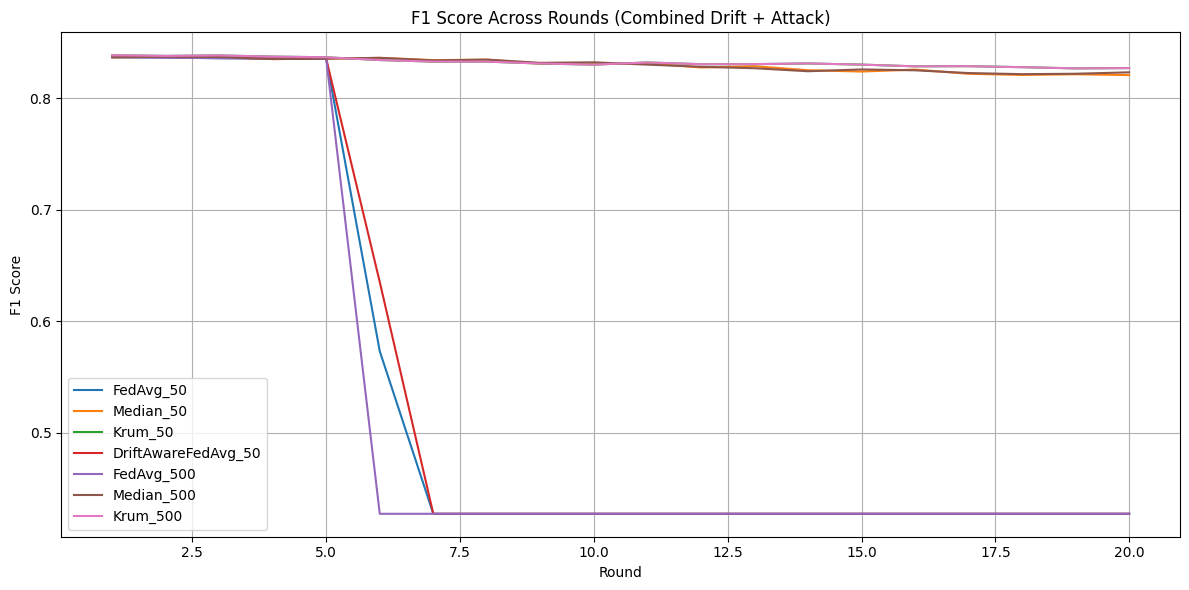

In [20]:
import matplotlib.pyplot as plt

# === Group by strategy ===
strategies_to_plot = [
    "FedAvg_50", "Median_50", "Krum_50",
    "DriftAwareFedAvg_50",
    "FedAvg_500", "Median_500", "Krum_500"
]

plt.figure(figsize=(12, 6))
for strategy in strategies_to_plot:
    subset = combined_summary[combined_summary["Strategy"] == strategy]
    plt.plot(subset["Round"], subset["F1"], label=strategy)

plt.title("F1 Score Across Rounds (Combined Drift + Attack)")
plt.xlabel("Round")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


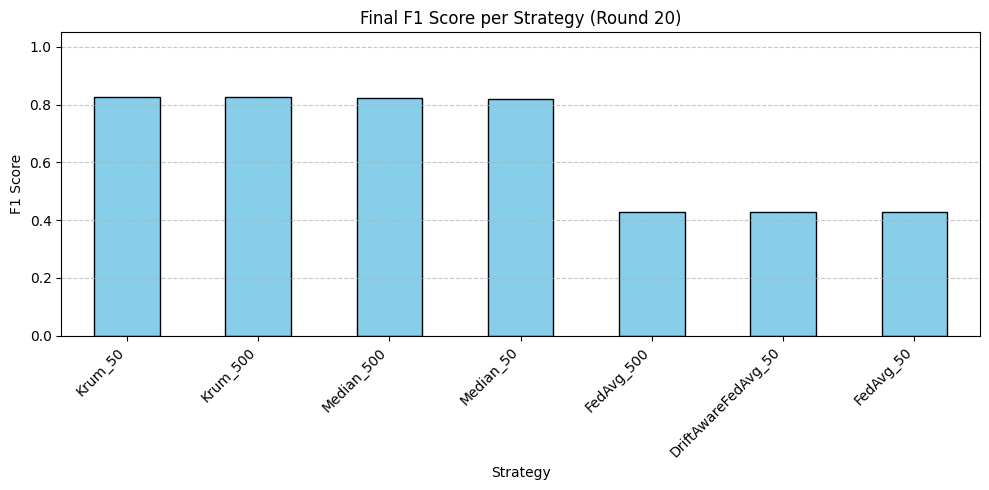

In [21]:
import matplotlib.pyplot as plt

# === Get final round (Round 20) F1 scores for each strategy ===
final_rounds = combined_summary[combined_summary["Round"] == 20]
final_f1 = final_rounds.groupby("Strategy")["F1"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
final_f1.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Final F1 Score per Strategy (Round 20)")
plt.ylabel("F1 Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
